<a href="https://colab.research.google.com/github/alibekk93/NLP_practice/blob/main/Micrograd_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Andrej Karpathy's Micrograd tutorial from https://www.youtube.com/watch?v=VMj-3S1tku0 and https://github.com/karpathy/nn-zero-to-hero/tree/master/lectures/micrograd

https://karpathy.ai/zero-to-hero.html

In [11]:
from tqdm import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Digraph

# Derivatives intuition

## Simple function

In [12]:
def f(x):
  return 3*x**2 - 4*x + 5

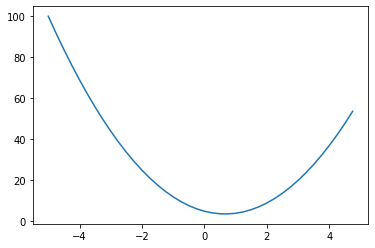

In [13]:
xs = np.arange(-5, 5, 0.25)
yx = f(xs)
plt.plot(xs, yx)

In [14]:
h = 1e-10
x = -3
(f(x + h) - f(x))/h

-21.999966293151374

## A more complex function

In [15]:
def f(a, b, c):
  return a*b + c

In [16]:
a = 2
b = -3
c = 10
d = f(a, b, c)
d

4

In [17]:
h = 1e-10

a = 2
b = -3
c = 10

d1 = f(a, b, c)
# derivative with respect to a
d2 = f(a + h, b, c)

print('A')
print(f'd1 = {d1}')
print(f'd2 = {d2}')
print(f'slope = {(d2 - d1)/h}')
print('---')

# derivative with respect to b
d2 = f(a, b + h, c)

print('B')
print(f'd1 = {d1}')
print(f'd2 = {d2}')
print(f'slope = {(d2 - d1)/h}')
print('---')

# derivative with respect to c
d2 = f(a, b, c + h)

print('C')
print(f'd1 = {d1}')
print(f'd2 = {d2}')
print(f'slope = {(d2 - d1)/h}')

A
d1 = 4
d2 = 3.9999999997
slope = -3.000000248221113
---
B
d1 = 4
d2 = 4.0000000002
slope = 2.000000165480742
---
C
d1 = 4
d2 = 4.0000000001
slope = 1.000000082740371


# Backpropagation

In [18]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [19]:
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2, label='f')
L = d*f; L.label = 'L'
print(d, d.label)
print(d._prev)
print(d._op)

Value(data=4) d
{Value(data=-6), Value(data=10)}
+


In [20]:
#@title ##### This code is for visualization and was copy-pasted

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## Simple NN-like structure

In [21]:
L.grad = 1 # dL/dL = 1
f.grad = d.data # L = d*f; dL/df = d
d.grad = f.data # L = d*f; dL/dd = f
e_local_grad = 1 # d = e + c; dd/de = 1
c_local_grad = 1 # d = e + c; dd/dc = 1
# chain rule: dL/de = (dL/dd)*(dd/de)
e.grad = e_local_grad*d.grad
c.grad = c_local_grad*d.grad
a.grad = b.data*e.grad # e = a*b; de/da = b; dL/da = (dL/de)*(de/da)
b.grad = a.data*e.grad # e = a*b; de/db = a; dL/db = (dL/de)*(de/db)

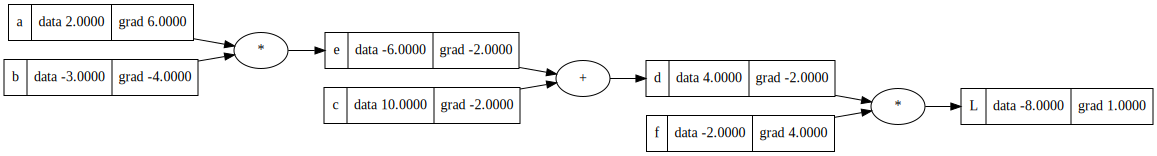

In [22]:
draw_dot(L)

## Neuron

In [23]:
# tan(X1W1 + X2W2 + bias) = output

### Manual backpropagation

In [24]:
# inputs x1,x2
x1 = Value(2.0, label='X1')
x2 = Value(0.0, label='X2')
# weights w1,w2
w1 = Value(-3.0, label='W1')
w2 = Value(1.0, label='W2')
# bias of the neuron
b = Value(6.8813735870195432, label='bias')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'X1W1'
x2w2 = x2*w2; x2w2.label = 'X2W2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'X1W1 + X2W2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

# chain rule
o.grad = 1 # do/do = 1
n.grad = 1 - o.data ** 2 # o = tanh(n); do/dn = 1 - o**2
b.grad = n.grad*1 # n = b + x1w1x2w2; dn/db = 1; do/db = do/dn*dn/db
x1w1x2w2.grad = b.grad*1 # n = b + x1w1x2w2; dn/dx1w1x2w2 = 1; do/x1w1x2w2 = do/dn*dn/x1w1x2w2
x1w1.grad = x1w1x2w2.grad*1
x2w2.grad = x1w1x2w2.grad*1
w1.grad = x1w1.grad*x1.data # x1w1 = x1*w1; dx1w1/dw1 = x1; do/dw1 = do/dx1w1*dx1w1/dw1
w2.grad = x2w2.grad*x2.data # x2w2 = x2*w2; dx2w2/dw2 = x2; do/dw2 = do/dx2w2*dx2w2/dw2
x1.grad = x1w1.grad*w1.data # x1w1 = x1*w1; dx1w1/dx1 = w1; do/dx1 = do/dx1w1*dx1w1/dx1
x2.grad = x1w1.grad*w2.data # x2w2 = x2*w2; dx2w2/dx2 = w2; do/dx2 = do/dx2w2*dx2w2/dx2

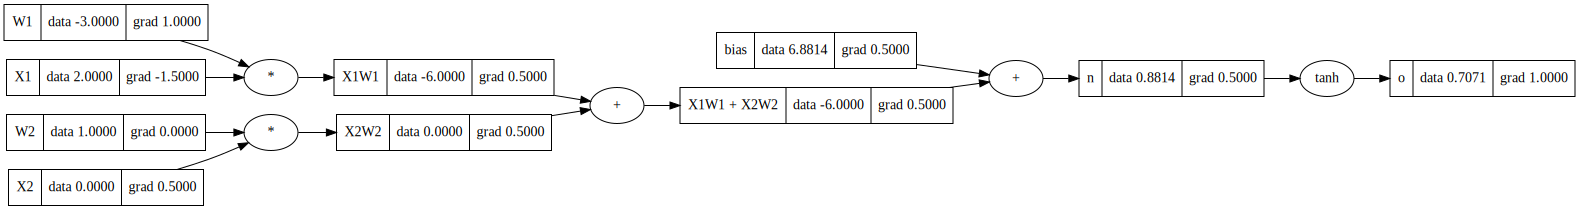

In [25]:
draw_dot(o)

### Automate backpropagation

In [26]:
# inputs x1,x2
x1 = Value(2.0, label='X1')
x2 = Value(0.0, label='X2')
# weights w1,w2
w1 = Value(-3.0, label='W1')
w2 = Value(1.0, label='W2')
# bias of the neuron
b = Value(6.8813735870195432, label='bias')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'X1W1'
x2w2 = x2*w2; x2w2.label = 'X2W2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'X1W1 + X2W2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

# automate backpropagarion
o.backward()

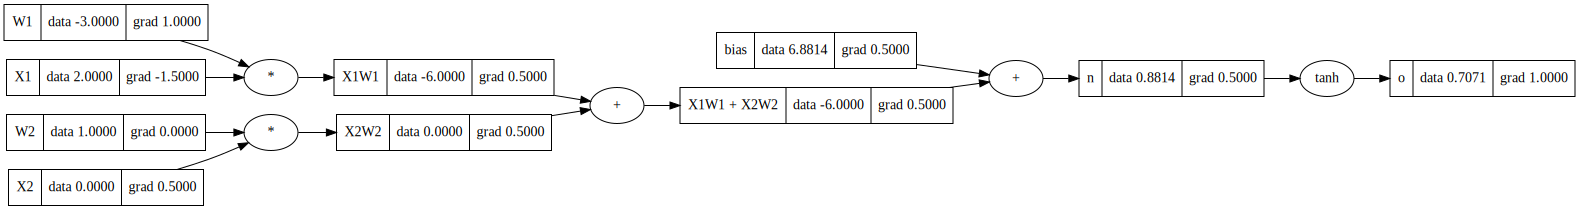

In [27]:
draw_dot(o)

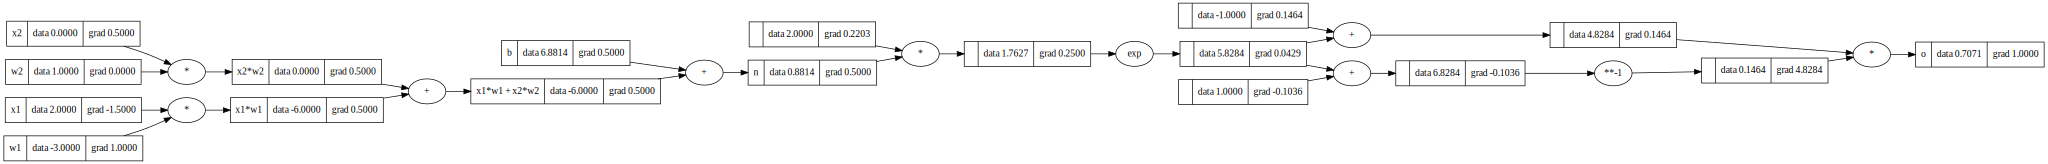

In [29]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

# PyTorch

In [33]:
import torch
import random

In [30]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [93]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [157]:
x = [2, 3, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.53366358377168)

In [158]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [159]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.53366358377168),
 Value(data=-0.7384210132539865),
 Value(data=-0.5679948809727834),
 Value(data=-0.521663351328208)]

In [160]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.922635332135577)

In [161]:
n.layers[0].neurons[0].w[0].data

-0.6246576126148862

In [162]:
n.layers[0].neurons[0].w[0].grad

0.0

In [163]:
loss.backward()

In [164]:
n.layers[0].neurons[0].w[0].grad

-0.12982520079116316

In [182]:
learning_rate = 0.05

n = MLP(3, [4, 4, 1])

for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -learning_rate * p.grad
  
  # print
  print(k, loss.data)

0 4.288511992907301
1 3.7760764715117734
2 3.3550162006509145
3 2.9176183427527156
4 2.434587328652469
5 1.9504025308579522
6 1.5200070582768914
7 1.170856242215225
8 0.9074180771122871
9 0.7150105250124703
10 0.5754973361661609
11 0.47289970832306694
12 0.39588083639850197
13 0.33684657991134925
14 0.2907063592448099
15 0.25399372104870144
16 0.22430708617954137
17 0.1999516240273113
18 0.17970904315398237
19 0.16268804833005912


In [185]:
ypred

[Value(data=0.8317651887803023),
 Value(data=-0.7918449548302445),
 Value(data=-0.7774427256365833),
 Value(data=0.7962235700032123)]

In [192]:
learning_rate = 0.01

n = MLP(3, [4, 4, 1])

plot_data = {}

for k in range(100):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -learning_rate * p.grad
  
  # record
  plot_data[k] = loss.data

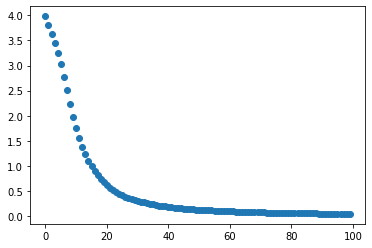

In [193]:
from  matplotlib import pyplot as plt
plt.scatter(x=plot_data.keys(), y = plot_data.values())

In [194]:
ypred

[Value(data=0.8919536817853633),
 Value(data=-0.8986132141034223),
 Value(data=-0.8917733594458271),
 Value(data=0.8867756833110313)]